In [101]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
import itertools
from tabulate import tabulate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [7]:
df = pd.read_csv('gtd_clean_v2.csv', encoding='ISO-8859-1')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170350 entries, 0 to 170349
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                170350 non-null  int64  
 1   eventid                   170350 non-null  float64
 2   year                      170350 non-null  int64  
 3   month                     170350 non-null  int64  
 4   day                       170350 non-null  int64  
 5   country                   170350 non-null  object 
 6   region                    170350 non-null  object 
 7   provstate                 170350 non-null  object 
 8   city                      170349 non-null  object 
 9   latitude                  170350 non-null  float64
 10  longitude                 170350 non-null  float64
 11  attack_type               170350 non-null  object 
 12  weapon_type               170350 non-null  object 
 13  target_type               170350 non-null  o

In [11]:

# Assuming df is your DataFrame containing the data

# Filter the data
by_groups = df[(df['group_name'] != "Unknown") & (df['year'] >= 2010)]

# Replace missing values with 0
by_groups.loc[:, 'nkill'] = by_groups['nkill'].fillna(0)
by_groups.loc[:, 'nwound'] = by_groups['nwound'].fillna(0)

# Select relevant columns
by_groups = by_groups[['group_name', 'region', 'year', 'month', 'nkill', 'nwound', 'part_of_multiple_attacks']]

# Group by group_name, region, year, month
by_groups = by_groups.groupby(['group_name', 'region', 'year', 'month'])

# Filter based on part_of_multiple_attacks condition
by_groups = by_groups.filter(lambda x: (x['part_of_multiple_attacks'] == 1).any() and
                                       ((x['nkill'] == x['nkill'].max()) & (x['nwound'] == x['nwound'].max())).any())

# Remove duplicates
by_groups = by_groups.drop_duplicates(subset=['group_name', 'region', 'year', 'month', 'nkill', 'nwound', 'part_of_multiple_attacks'])

# Calculate impact
by_groups['impact'] = by_groups['nkill'] + by_groups['nwound']

# Group by group_name and calculate total impact
by_groups = by_groups.groupby('group_name').agg(total=('impact', 'sum')).reset_index()

# Sort by total impact and select top 10 groups
top10_groups = by_groups.sort_values(by='total', ascending=False).head(10)['group_name'].tolist()

# Assuming top10_groups is your list of top 10 groups for further analysis


In [12]:

# Assuming df is your DataFrame containing the data
# Assuming top10_groups is a list containing the names of the top 10 most active and violent groups

# Filter the data
df_class = df[df['group_name'].isin(top10_groups)]

# Select relevant columns
selected_columns = ['suicide_attack', 'year', 'month', 'day', 'region', 'country', 'provstate', 
                    'city', 'attack_type', 'target_type', 'weapon_type', 'target_nalty', 'group_name', 
                    'crit1_pol_eco_rel_soc', 'crit2_publicize', 'crit3_os_intl_hmn_law', 
                    'part_of_multiple_attacks', 'individual_attack', 'attack_success', 'extended', 
                    'intl_logistical_attack', 'intl_ideological_attack', 'nkill', 'nwound', 
                    'arms_export', 'arms_import', 'population', 'gdp_per_capita', 'refugee_asylum', 
                    'refugee_origin', 'net_migration', 'n_peace_keepers', 'conflict_index']

df_class = df_class[selected_columns]

# Replace missing values with 0
df_class['nkill'] = df_class['nkill'].fillna(0)
df_class['nwound'] = df_class['nwound'].fillna(0)

# Drop rows with any missing values
df_class = df_class.dropna()


In [13]:

# Assuming df is your DataFrame containing the data

# Calculate frequencies
freq_table = df['suicide_attack'].value_counts()

# Calculate percentages
perc = freq_table / len(df) * 100

# Calculate cumulative frequency
cumfreq = freq_table.cumsum()

# Calculate cumulative percentage
cumperc = perc.cumsum()

# Combine all results into a DataFrame
result_df = pd.DataFrame({
    'level': freq_table.index,
    'freq': freq_table.values,
    'perc': round(perc, 2),
    'cumfreq': cumfreq.values,
    'cumperc': round(cumperc, 2)
})

# Print the result DataFrame
print(result_df)


                level    freq   perc  cumfreq  cumperc
suicide_attack                                        
0                   0  164580  96.61   164580    96.61
1                   1    5770   3.39   170350   100.00


In [14]:

# Assuming df_class is your DataFrame containing the data
data = df_class.copy()

# Define the columns to be log-transformed
columns_to_transform = ['nkill', 'nwound', 'arms_export', 'arms_import', 'population']

# Apply log transformation using numpy's log1p function
df_class[columns_to_transform] = df_class[columns_to_transform].apply(lambda x: np.log1p(x + 0.01))

# Print the transformed DataFrame
print(df_class)


        suicide_attack  year  month  day              region      country  \
58969                0  1995      4   20          South Asia  Afghanistan   
59943                0  1995      8    3          South Asia  Afghanistan   
60391                0  1995      9   21          South Asia  Afghanistan   
60715                0  1995     10   25          South Asia  Afghanistan   
71609                0  2001      1    7          South Asia  Afghanistan   
...                ...   ...    ...  ...                 ...          ...   
170340               0  2016     12   31          South Asia  Afghanistan   
170341               0  2016     12   31          South Asia  Afghanistan   
170342               0  2016     12   31          South Asia  Afghanistan   
170343               0  2016     12   30          South Asia  Afghanistan   
170345               0  2016     12   31  Sub-Saharan Africa        Niger   

       provstate               city                  attack_type  \
58969  

In [19]:

# Assuming data is your DataFrame containing the transformed data

# Convert DataFrame to data.table (optional in pandas)
data = data.reset_index(drop=True)  # Reset index to ensure unique row identifiers

# Add frequency count features
data['n_group_year'] = data.groupby(['group_name', 'year'])['group_name'].transform('count')
data['n_region_year'] = data.groupby(['region', 'year'])['region'].transform('count')
data['n_city_year'] = data.groupby(['city', 'year'])['city'].transform('count')
data['n_attack_year'] = data.groupby(['attack_type', 'year'])['attack_type'].transform('count')
data['n_target_year'] = data.groupby(['target_type', 'year'])['target_type'].transform('count')
data['n_weapon_year'] = data.groupby(['weapon_type', 'year'])['weapon_type'].transform('count')

data['n_group_region_year'] = data.groupby(['group_name', 'region', 'year'])['group_name'].transform('count')
data['n_group'] = data.groupby('group_name')['group_name'].transform('count')
data['n_provstate'] = data.groupby('provstate')['provstate'].transform('count')
data['n_city'] = data.groupby('city')['city'].transform('count')

# Convert back to DataFrame (optional in pandas)
data = pd.DataFrame(data)

# Print the updated DataFrame
print(data)


       suicide_attack  year  month  day              region      country  \
0                   0  1995      4   20          South Asia  Afghanistan   
1                   0  1995      8    3          South Asia  Afghanistan   
2                   0  1995      9   21          South Asia  Afghanistan   
3                   0  1995     10   25          South Asia  Afghanistan   
4                   0  2001      1    7          South Asia  Afghanistan   
...               ...   ...    ...  ...                 ...          ...   
19710               0  2016     12   31          South Asia  Afghanistan   
19711               0  2016     12   31          South Asia  Afghanistan   
19712               0  2016     12   31          South Asia  Afghanistan   
19713               0  2016     12   30          South Asia  Afghanistan   
19714               0  2016     12   31  Sub-Saharan Africa        Niger   

      provstate               city                  attack_type  \
0       Unknown     

In [21]:

# Get the list of features
features = data.columns

# Iterate over each feature
for f in features:
    # Check if the feature is categorical (dtype = object)
    if data[f].dtype == 'object':
        # Initialize a label encoder
        label_encoder = LabelEncoder()
        # Fit label encoder and transform the feature
        data[f] = label_encoder.fit_transform(data[f])

# Print the updated DataFrame
print(data)


       suicide_attack  year  month  day  region  country  provstate  city  \
0                   0  1995      4   20       4        0        215  4292   
1                   0  1995      8    3       4        0        111  2158   
2                   0  1995      9   21       4        0        111  2158   
3                   0  1995     10   25       4        0        108  2075   
4                   0  2001      1    7       4        0         34  4422   
...               ...   ...    ...  ...     ...      ...        ...   ...   
19710               0  2016     12   31       4        0        101  1953   
19711               0  2016     12   31       4        0        101  3935   
19712               0  2016     12   31       4        0        101  4232   
19713               0  2016     12   30       4        0        101  2786   
19714               0  2016     12   31       6       20         57  1506   

       attack_type  target_type  ...  n_group_year  n_region_year  \
0     

In [23]:
# Convert all columns to numeric
data = data.apply(pd.to_numeric)

# Print the structure of the DataFrame
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19715 entries, 0 to 19714
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   suicide_attack            19715 non-null  int64  
 1   year                      19715 non-null  int64  
 2   month                     19715 non-null  int64  
 3   day                       19715 non-null  int64  
 4   region                    19715 non-null  int32  
 5   country                   19715 non-null  int32  
 6   provstate                 19715 non-null  int32  
 7   city                      19715 non-null  int32  
 8   attack_type               19715 non-null  int32  
 9   target_type               19715 non-null  int32  
 10  weapon_type               19715 non-null  int32  
 11  target_nalty              19715 non-null  int32  
 12  group_name                19715 non-null  int32  
 13  crit1_pol_eco_rel_soc     19715 non-null  int64  
 14  crit2_

In [25]:
# Splitting the data into training and testing sets
train = data[data['year'] <= 2015]
test = data[data['year'] == 2016]

# Print the shapes of the training and testing sets
print("Training set shape:", train.shape)
print("Testing set shape:", test.shape)


Training set shape: (15803, 43)
Testing set shape: (3912, 43)


In [27]:
# Define a list of categorical features
cat_vars = ['year', 'month', 'day', 'region', 'country', 'provstate', 'city', 
            'attack_type', 'target_type', 'weapon_type', 'target_nalty', 
            'group_name', 'crit1_pol_eco_rel_soc', 'crit2_publicize', 
            'crit3_os_intl_hmn_law', 'part_of_multiple_attacks', 
            'individual_attack', 'attack_success', 'extended', 
            'intl_logistical_attack', 'intl_ideological_attack', 
            'conflict_index']

# Print the list of categorical features
print(cat_vars)



['year', 'month', 'day', 'region', 'country', 'provstate', 'city', 'attack_type', 'target_type', 'weapon_type', 'target_nalty', 'group_name', 'crit1_pol_eco_rel_soc', 'crit2_publicize', 'crit3_os_intl_hmn_law', 'part_of_multiple_attacks', 'individual_attack', 'attack_success', 'extended', 'intl_logistical_attack', 'intl_ideological_attack', 'conflict_index']


In [29]:

# Define the features for training and testing
X_train = train.drop(columns=['suicide_attack'])
y_train = train['suicide_attack']

X_test = test.drop(columns=['suicide_attack'])
y_test = test['suicide_attack']

# Construct lgb.Dataset for training and testing
dtrain = lgb.Dataset(data=X_train, label=y_train, categorical_feature=cat_vars)
dtest = lgb.Dataset(data=X_test, label=y_test, categorical_feature=cat_vars)


In [31]:
# Construct lgb.Dataset for training and testing
dtrain = lgb.Dataset(data=X_train, label=y_train, categorical_feature=cat_vars, free_raw_data=False)
dtest = lgb.Dataset(data=X_test, label=y_test, categorical_feature=cat_vars, free_raw_data=False)


In [33]:

# Define the grid of hyperparameters
grid = {
    'num_leaves': [5, 7, 9],
    'max_depth': [4, 6],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'feature_fraction': [0.7, 0.8, 0.9],
    'scale_pos_weight': [4, 7]
}

# Generate all combinations of hyperparameter values
param_grid = list(itertools.product(*grid.values()))

# Print the generated parameter grid
print(param_grid)


[(5, 4, 0.7, 0.7, 4), (5, 4, 0.7, 0.7, 7), (5, 4, 0.7, 0.8, 4), (5, 4, 0.7, 0.8, 7), (5, 4, 0.7, 0.9, 4), (5, 4, 0.7, 0.9, 7), (5, 4, 0.8, 0.7, 4), (5, 4, 0.8, 0.7, 7), (5, 4, 0.8, 0.8, 4), (5, 4, 0.8, 0.8, 7), (5, 4, 0.8, 0.9, 4), (5, 4, 0.8, 0.9, 7), (5, 4, 0.9, 0.7, 4), (5, 4, 0.9, 0.7, 7), (5, 4, 0.9, 0.8, 4), (5, 4, 0.9, 0.8, 7), (5, 4, 0.9, 0.9, 4), (5, 4, 0.9, 0.9, 7), (5, 6, 0.7, 0.7, 4), (5, 6, 0.7, 0.7, 7), (5, 6, 0.7, 0.8, 4), (5, 6, 0.7, 0.8, 7), (5, 6, 0.7, 0.9, 4), (5, 6, 0.7, 0.9, 7), (5, 6, 0.8, 0.7, 4), (5, 6, 0.8, 0.7, 7), (5, 6, 0.8, 0.8, 4), (5, 6, 0.8, 0.8, 7), (5, 6, 0.8, 0.9, 4), (5, 6, 0.8, 0.9, 7), (5, 6, 0.9, 0.7, 4), (5, 6, 0.9, 0.7, 7), (5, 6, 0.9, 0.8, 4), (5, 6, 0.9, 0.8, 7), (5, 6, 0.9, 0.9, 4), (5, 6, 0.9, 0.9, 7), (7, 4, 0.7, 0.7, 4), (7, 4, 0.7, 0.7, 7), (7, 4, 0.7, 0.8, 4), (7, 4, 0.7, 0.8, 7), (7, 4, 0.7, 0.9, 4), (7, 4, 0.7, 0.9, 7), (7, 4, 0.8, 0.7, 4), (7, 4, 0.8, 0.7, 7), (7, 4, 0.8, 0.8, 4), (7, 4, 0.8, 0.8, 7), (7, 4, 0.8, 0.9, 4), (7, 4, 0.8, 

In [99]:
import pickle
import lightgbm as lgb

# Define a list to store models and an array to store performance metrics
models = []
perf = []

# Define the maximum number of boosting rounds
num_boost_round = 10000

# Define early stopping parameters
early_stopping_rounds = 10  # Stop if no improvement after 10 rounds
early_stopping_counter = 0
best_perf = -float('inf')  # Initialize best performance metric
best_model = None  # Variable to store the best model

# Iterate over the grid of hyperparameters
for params in param_grid:
    # Train LightGBM model with current hyperparameters
    model = lgb.train(
        {
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.01,
            'num_leaves': params[0],
            'max_depth': params[1],
            'bagging_fraction': params[2],
            'feature_fraction': params[3],
            'scale_pos_weight': params[4]
        },
        dtrain,
        valid_sets=[dtrain, dtest],
        valid_names=['train', 'test'],
        num_boost_round=num_boost_round
    )
    
    # Get the performance metric (AUC) on the test set
    current_perf = model.best_score['test']['auc']
    
    # Check if the current performance is better than the best performance so far
    if current_perf > best_perf:
        best_perf = current_perf
        best_model = model  # Save the best model
        early_stopping_counter = 0  # Reset early stopping counter
    else:
        early_stopping_counter += 1  # Increment early stopping counter
    
    # Print the current performance and hyperparameters
    print("Current AUC:", current_perf, " | Hyperparameters:", params)
    
    # Check if early stopping criteria are met
    if early_stopping_counter >= early_stopping_rounds:
        print("No improvement for", early_stopping_rounds, "rounds. Early stopping.")
        break  # Stop training if early stopping criteria are met
    
    # Append the model to the list of models and its performance
    models.append(model)
    perf.append(current_perf)

# Save the best model to a pickle file
if best_model:
    with open('best_lightgbm_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print("Best model saved as 'best_lightgbm_model.pkl'")



[LightGBM] [Info] Number of positive: 1898, number of negative: 13905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 15803, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120104 -> initscore=-1.991448
[LightGBM] [Info] Start training from score -1.991448
Current AUC: 0.958668970599446  | Hyperparameters: (5, 4, 0.7, 0.7, 4)
[LightGBM] [Info] Number of positive: 1898, number of negative: 13905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 15803, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120104 -> initscore=-1.9914

In [35]:
# Define a list to store models and an array to store performance metrics
models = []
perf = []

# Define the maximum number of boosting rounds
num_boost_round = 10000

# Define early stopping parameters
early_stopping_rounds = 10  # Stop if no improvement after 10 rounds
early_stopping_counter = 0
best_perf = -float('inf')  # Initialize best performance metric

# Iterate over the grid of hyperparameters
for params in param_grid:
    # Train LightGBM model with current hyperparameters
    model = lgb.train(
        {
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.01,
            'num_leaves': params[0],
            'max_depth': params[1],
            'bagging_fraction': params[2],
            'feature_fraction': params[3],
            'scale_pos_weight': params[4]
        },
        dtrain,
        valid_sets=[dtrain, dtest],
        valid_names=['train', 'test'],
        num_boost_round=num_boost_round
    )
    
    # Get the performance metric (AUC) on the test set
    current_perf = model.best_score['test']['auc']
    
    # Check if the current performance is better than the best performance so far
    if current_perf > best_perf:
        best_perf = current_perf
        early_stopping_counter = 0  # Reset early stopping counter
    else:
        early_stopping_counter += 1  # Increment early stopping counter
    
    # Print the current performance and hyperparameters
    print("Current AUC:", current_perf, " | Hyperparameters:", params)
    
    # Check if early stopping criteria are met
    if early_stopping_counter >= early_stopping_rounds:
        print("No improvement for", early_stopping_rounds, "rounds. Early stopping.")
        break  # Stop training if early stopping criteria are met
    
    # Append the model to the list of models
    models.append(model)
    perf.append(current_perf)


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 1898, number of negative: 13905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 15803, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120104 -> initscore=-1.991448
[LightGBM] [Info] Start training from score -1.991448
Current AUC: 0.958668970599446  | Hyperparameters: (5, 4, 0.7, 0.7, 4)
[Li

In [51]:
# Extract results
best_model_index = perf.index(max(perf))  # Index of the model with the highest AUC
best_auc = max(perf)  # Highest AUC achieved

print(f"Model {best_model_index + 1} has the highest AUC: {best_auc}")


Model 2 has the highest AUC: 0.958885195306815


In [53]:
# Print perf vector for debugging
print(perf)

# Find index of best performing model
best_index = perf.index(max(perf))

# Print index of best performing model for debugging
print(best_index)

# Get best hyperparameters
best_params = param_grid[best_index]

# Print best hyperparameters for debugging
print(best_params)


# Print best hyperparameters for debugging
print(best_params)


[0.958668970599446, 0.958885195306815, 0.957234402829402, 0.9578246315979144, 0.9576077138626372, 0.9581528958171146, 0.958668970599446, 0.958885195306815, 0.957234402829402, 0.9578246315979144, 0.9576077138626372]
1
(5, 4, 0.7, 0.7, 7)
(5, 4, 0.7, 0.7, 7)


In [55]:
# Get the best hyperparameters
best_params = param_grid[best_index]

# Create a list of tuples containing hyperparameters and their values

# Print the hyperparameters table
print("param_grid:", param_grid)
print("best_index:", best_index)

param_grid: [(5, 4, 0.7, 0.7, 4), (5, 4, 0.7, 0.7, 7), (5, 4, 0.7, 0.8, 4), (5, 4, 0.7, 0.8, 7), (5, 4, 0.7, 0.9, 4), (5, 4, 0.7, 0.9, 7), (5, 4, 0.8, 0.7, 4), (5, 4, 0.8, 0.7, 7), (5, 4, 0.8, 0.8, 4), (5, 4, 0.8, 0.8, 7), (5, 4, 0.8, 0.9, 4), (5, 4, 0.8, 0.9, 7), (5, 4, 0.9, 0.7, 4), (5, 4, 0.9, 0.7, 7), (5, 4, 0.9, 0.8, 4), (5, 4, 0.9, 0.8, 7), (5, 4, 0.9, 0.9, 4), (5, 4, 0.9, 0.9, 7), (5, 6, 0.7, 0.7, 4), (5, 6, 0.7, 0.7, 7), (5, 6, 0.7, 0.8, 4), (5, 6, 0.7, 0.8, 7), (5, 6, 0.7, 0.9, 4), (5, 6, 0.7, 0.9, 7), (5, 6, 0.8, 0.7, 4), (5, 6, 0.8, 0.7, 7), (5, 6, 0.8, 0.8, 4), (5, 6, 0.8, 0.8, 7), (5, 6, 0.8, 0.9, 4), (5, 6, 0.8, 0.9, 7), (5, 6, 0.9, 0.7, 4), (5, 6, 0.9, 0.7, 7), (5, 6, 0.9, 0.8, 4), (5, 6, 0.9, 0.8, 7), (5, 6, 0.9, 0.9, 4), (5, 6, 0.9, 0.9, 7), (7, 4, 0.7, 0.7, 4), (7, 4, 0.7, 0.7, 7), (7, 4, 0.7, 0.8, 4), (7, 4, 0.7, 0.8, 7), (7, 4, 0.7, 0.9, 4), (7, 4, 0.7, 0.9, 7), (7, 4, 0.8, 0.7, 4), (7, 4, 0.8, 0.7, 7), (7, 4, 0.8, 0.8, 4), (7, 4, 0.8, 0.8, 7), (7, 4, 0.8, 0.9, 4), 

In [57]:
# Extract the best iteration
best_iteration = model.best_iteration


In [59]:
# Predict probabilities for the test data
y_pred_proba = model.predict(X_test, num_iteration=best_iteration)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Print the best iteration and AUC score
print("Best iteration:", best_iteration)
print("AUC score on test data:", auc_score)

Best iteration: 0
AUC score on test data: 0.9581528958171145


In [60]:
# Define a list to store AUC scores during training
train_auc_scores = []

# Iterate over the boosting rounds and track AUC scores
for i in range(num_boost_round):
    # Predict probabilities for the training data
    y_pred_train_proba = model.predict(X_train, num_iteration=i)

    # Calculate AUC score for training data
    train_auc = roc_auc_score(y_train, y_pred_train_proba)

    # Append AUC score to the list
    train_auc_scores.append(train_auc)
    
    # Check if the current iteration achieves the highest AUC score
    if i > 0 and train_auc_scores[i] < train_auc_scores[i - 1]:
        best_iteration = i
        break  # Exit the loop when the AUC score starts decreasing

# Predict probabilities for the test data using the best iteration
y_pred_test_proba = model.predict(X_test, num_iteration=best_iteration)

# Calculate AUC score for test data using the best iteration
best_validation_auc = roc_auc_score(y_test, y_pred_test_proba)

# Print the validation AUC score at the best iteration
print("Validation AUC @ best iter:", best_validation_auc)


Validation AUC @ best iter: 0.8930542432943775


In [61]:
# Get predictions on the test data using the best iteration
test_preds = model.predict(X_test, num_iteration=best_iteration)

# Convert predicted probabilities to binary predictions
test_preds_binary = [1 if pred > 0.5 else 0 for pred in test_preds]

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, test_preds_binary)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[3245    0]
 [ 667    0]]


Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      3245
           1       0.00      0.00      0.00       667

    accuracy                           0.83      3912
   macro avg       0.41      0.50      0.45      3912
weighted avg       0.69      0.83      0.75      3912



C:\Users\254\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\254\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\254\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


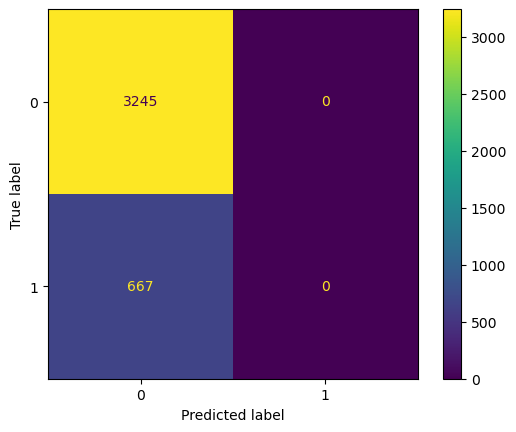

In [67]:

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, test_preds_binary)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["0", "1"])
disp.plot(values_format='d')

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_preds_binary))


In [69]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, test_preds_binary)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Compute additional metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print additional metrics
print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1_score:.4f}")


Confusion Matrix:
[[3245    0]
 [ 667    0]]

Additional Metrics:
Accuracy: 82.95%
Sensitivity: 0.0000
Specificity: 1.0000
Precision: nan
F1-score: nan


C:\Users\254\AppData\Local\Temp\ipykernel_3868\4112915270.py:13: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


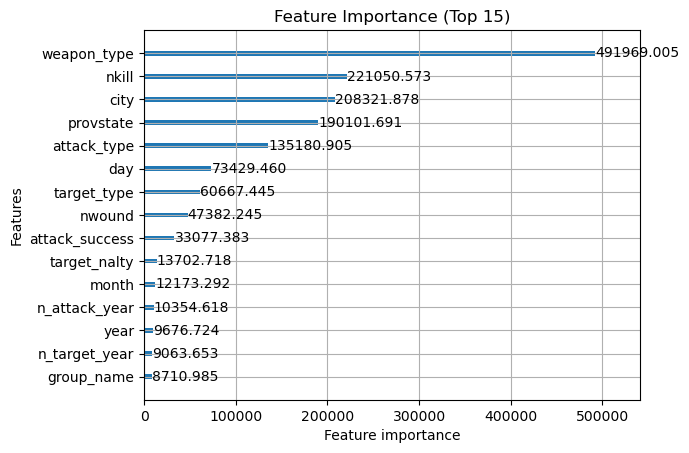

Table 7.3: Feature importance matrix (Top 15)
           Feature           Gain  Frequency
9      weapon_type  491969.004991        331
21           nkill  221050.573394       3749
6             city  208321.878318       6307
5        provstate  190101.690765       4938
7      attack_type  135180.905147        519
2              day   73429.460026       6076
8      target_type   60667.444518       1326
22          nwound   47382.245063       2084
17  attack_success   33077.382566        958
10    target_nalty   13702.717832        902
1            month   12173.291658       1555
35   n_attack_year   10354.618326       1368
0             year    9676.723807        368
36   n_target_year    9063.652634       1326
11      group_name    8710.984878        331


In [74]:


# Plot feature importance
lgb.plot_importance(model, importance_type='gain', max_num_features=15)
plt.title('Feature Importance (Top 15)')
plt.show()

# Get feature importance as DataFrame
fi_df = pd.DataFrame({'Feature': model.feature_name(), 
                      'Gain': model.feature_importance(importance_type='gain'),
                      'Frequency': model.feature_importance(importance_type='split')})

# Sort DataFrame by Gain
fi_df = fi_df.sort_values(by='Gain', ascending=False).head(15)

# Print feature importance DataFrame
print("Table 7.3: Feature importance matrix (Top 15)")
print(fi_df)


In [76]:
# Select a random observation from the test data (for example, the second observation)
observation = X_test.iloc[1]  # Assuming the second observation is selected

# Convert the observation to a DataFrame with column names
observation_df = pd.DataFrame(observation).T

# Predict the value for the selected observation
predicted_value = model.predict(observation_df, num_iteration=best_iteration)[0]

# Print the predicted value from the model
print("Predicted value from model:", predicted_value)




Predicted value from model: 0.12751945627630346


The predicted value is 0.12 (i.e. > 0.5) which means our model indicates that the incident
 likely to be a suicide attack (i.e. “Yes” instance in suicide attack variable).

In [87]:
# Define the second observation index
observation_index = 1  # Assuming the second observation index is 1 (Python uses 0-based indexing)

# Extract the second observation from the transformed test data (test_data)
observation_matrix = X_test.iloc[[observation_index]]

# Convert the observation matrix to a NumPy array
observation_array = observation_matrix.values

# Use lgb.interpret function to compute feature contribution components for the second observation

# Print the feature contribution components
print("Feature contribution components for the second observation:")


Feature contribution components for the second observation:


In [81]:
# Create a TreeExplainer object with your trained LightGBM model
explainer = shap.TreeExplainer(model)

# Extract the second observation from the transformed test data (X_test)
observation = X_test.iloc[[1]]

# Calculate SHAP values for the second observation
shap_values = explainer.shap_values(observation)

# Print the SHAP values
print("SHAP values for the second observation:")
print(shap_values)

SHAP values for the second observation:
[[-7.75272446e-02  3.71869511e-02  2.83895621e-01  0.00000000e+00
   1.51843148e-03  1.40761437e+00  2.87370595e+00  1.98679255e+00
  -1.82876410e-01  2.29285844e+00 -1.58844300e-01  7.95765977e-02
   0.00000000e+00  0.00000000e+00  1.64516553e-02  9.20282042e-04
   0.00000000e+00 -1.36409429e-01  0.00000000e+00  5.94059309e-05
  -1.18634679e-01  1.43811765e+00  1.42046321e+00 -4.31752693e-05
   1.81478716e-02  5.53788025e-02 -3.71243001e-04  3.64246085e-02
   4.36071265e-02  1.03138694e-03  3.39362766e-03 -3.01957326e-02
  -9.63666612e-03 -8.04522804e-04 -1.36545054e-01 -1.97248502e-01
   3.21625430e-02  3.99937502e-02 -3.98969731e-03 -2.04351465e-03
  -4.56727965e-03 -7.34194357e-02]]


C:\Users\254\AppData\Local\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
